# Dynamics of an End-mirror Optomechanical System

In this notebook, the following topics are covered:

* [The Heisenberg-Langevin Equations (HLE)](#the-heisenberg-langevin-equations-hle)
* [The Quantum Optomechanics (QOM) Toolbox](#the-quantum-optomechanics-qom-toolbox)
* [Nonlinear Classical Dynamics](#nonlinear-classical-dynamics)
* [Optomechanical Bistability](#optomechanical-bistability)
* [Optomechanical Damping and Optical Spring Effect](#optomechanical-damping-and-optical-spring-effect)
* [Correlations between the Quantum Fluctuations](#correlations-between-the-quantum-fluctuations)
* [Optomechanical Entanglement](#optomechanical-entanglement)
* [Visualizing the Cached Dynamics](#visualizing-the-cached-dynamics)

## The Heisenberg-Langevin Equations (HLE)

The Hamiltonian of a simple optomechanical system can be written as (refer to [our tutorial](https://arxiv.org/abs/2211.02596) for its derivation):
$$
H = - \hbar \Delta_{0} a^{\dagger} a + \hbar \omega_{m} b^{\dagger} b - \hbar g_{0} a^{\dagger} a \left( b^{\dagger} + b \right) + i \hbar A_{l} \left( a^{\dagger} - a \right),
$$
where $a$ ($b$) is the annihilation operator of the optical (mechanical) mode, $\Delta_{0}$ is the laser detuning, $\omega_{m}$ the mechanical resonance frequency, $g_{0}$ the optomechanical interaction strength and $A_{l}$ the laser amplitude.

In the linearized limit, this Hamiltonian can be represented by:
* Classical complex-valued modes ($\alpha$, $\beta$) obeying coupled differential equations.
* Quantum real-valued quadratures ($X$, $Y$, $Q$, $P$) whose correlations obey a simple matrix equation.

The coupled differential equations are
$$
\frac{d \alpha}{d \tau} = - \left( \frac{\kappa^{\prime}}{2} - i \Delta_{0}^{\prime} \right) \alpha + i g_{0}^{\prime} \alpha \left( \beta^{*} + \beta \right) + A_{l}^{\prime}, \\
\frac{d \beta}{d \tau} = - \left( \frac{\gamma^{\prime}}{2} + i \right) \beta + i g_{0}^{\prime} \alpha^{*} \alpha,
$$
where $\kappa$ ($\gamma$) are the optical decay (mechanical damping) rates.
The prime superscript denotes normalization with $\omega_{m}$ with $\tau = \omega_{m} t$.

The equation of the quadrature correlation can be simplified as
$$
\frac{d \mathbf{V}}{d \tau} = \mathbf{A}^{\prime} \mathbf{V} + \mathbf{V} \mathbf{A}^{\prime T} + \mathbf{D}^{\prime},
$$
where $\mathbf{V}_{jk} = \frac{1}{2} \langle u_{j} u_{k} + u_{k} u_{j} \rangle$, with $\mathbf{u} = (X, Y, Q, P)^{T}$, the normalized noise matrix $\mathbf{D}^{\prime} = \mathrm{Diag}[\kappa^{\prime} / 2, \kappa^{\prime} / 2, \gamma^{\prime} (n_{th} + 1 / 2), \gamma^{\prime} (n_{th} + 1 / 2)]$ with $n_{th}$ being the thermal mechanical vibration quanta, and the normalized drift matrix $\mathbf{A}^{\prime}$ is
$$
\begin{pmatrix}
    - \frac{\kappa^{\prime}}{2} & - \Delta^{\prime} & - 2 G_{0I}^{\prime} & 0 \\
    \Delta^{\prime} & - \frac{\kappa^{\prime}}{2} & 2 G_{0R}^{\prime} & 0 \\
    0 & 0 & - \frac{\gamma^{\prime}}{2} & \omega_{m}^{\prime} \\
    2 G_{0R}^{\prime} & 2 G_{0I}^{\prime} & - \omega_{m}^{\prime} & - \frac{\gamma^{\prime}}{2}
\end{pmatrix},
$$
where $\Delta^{\prime} = \Delta_{0}^{\prime} + g_{0}^{\prime} ( \beta^{*} + \beta )$ and $G_{0R}^{\prime}$ ($G_{0I}^{\prime}$) are the real (imaginary) parts of $G_{0}^{\prime} = g_{0}^{\prime} \alpha$.

## The Quantum Optomechanics (QOM) Toolbox 

The Quantum Optomechanics Toolbox, packaged as [`qom`](https://github.com/sampreet/qom), is a wrapper-styled toolbox to simulate the classical and quantum dynamics of optomechanical models in a scalable manner.
Its key features include:
* Run automatically-managed loops in parallel and pool results.
* Solve for stability and classical/quantum signatures seamlessly.
* Configure plots across plotting libraries with a common syntax.

Let's initialize the library...

In [1]:
# qom modules
from qom.ui import init_log
# initialize log
init_log()

MainThread               INFO    2023-07-13 13:15:50.272: (qom.ui.log) -------------------------------------------------Logger Initialized


The dynamics are best calculated when the system is written as an inherited class containing methods to obtain the drift matrix $A$ (`get_A`), the initial values of the variables and the constants of the system including the noise matrix $D$ and the parameters (`get_ivc`) and the rate equations of the classical dynamics (`get_mode_rates`).
For example, a typical optomechanical system following the HLEs defined in the previous section can be written as the [EM_00 class](../../systems/EndMirror.py).
Let's import this system...

In [2]:
# import dependencies
import numpy as np
import os
import sys
# adding the path to the system
sys.path.append(os.path.abspath(os.path.join('../..')))
# import system
from systems.EndMirror import EM_00

We next initialize the system with some values of the parameters and run the `HLESolver` class of the `qom.solvers.deterministic` module to obtain the dynamics of the system.
The `get_mode_indices` method returns the dynamics of the required mode indices in a given range of time.
Let us plot the mode dynamics of $(\beta^{*} + \beta) / \sqrt{2}$ (which also corresponds to the classical position $q$ of the mechanical oscillator) by setting the parameter `indices` to `[1]` with the default time range (all times).

Here, the dynamics are calculated using the FORTRAN submodule `vode` upto $\tau_{max} = 1000.0$ with $10001$ values from $0$ to $\tau_{max}$ and saved as a compressed NumPy array into the `cache/em_00/0.0_1000.0_10001_vode` folder, where `em_00` is the codename of the system.
Note that the calculated dynamics are returned with the first axis corresponding to the number of time steps (to facilitate `indices` taking a list of mode indices and returning the dynamics of each as list of values for each time step).
The plotting is done using the `MPLPlotter` class in the `qom.ui.plotters.matplotlib` module, taking only the `'real'` components of the amplitudes for `component`.

MainThread               INFO    2023-07-13 13:15:56.857: (qom.solvers.HLESolver) ----------------------------------------Results Obtained	
MainThread               INFO    2023-07-13 13:15:56.991: (qom.ui.plotters.MPLPlotter) -----Plotting only Real Parts of the Complex Values	
	


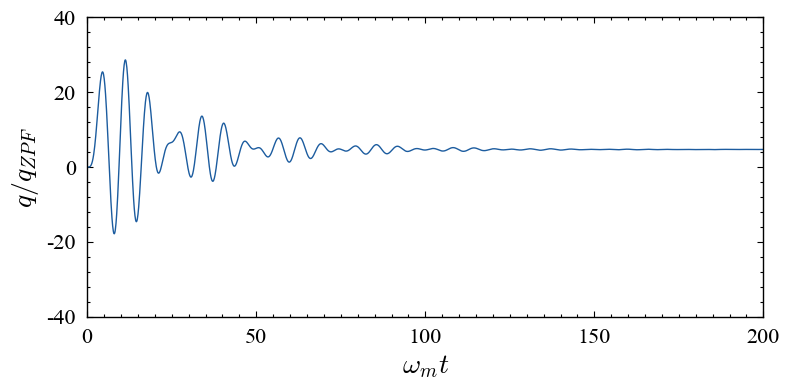

In [3]:
# qom modules
from qom.solvers.deterministic import HLESolver
from qom.ui.plotters import MPLPlotter

# system parameters
system_params = {
    'A_l_norm': 25.0,
    'Delta_0_norm': -1.0, 
    'g_0_norm': 0.005,
    'gamma_norm': 0.005,
    'kappa_norm': 0.15,
    'T_norm': 0.0
}
# initialize system
system = EM_00(
    params=system_params
)

# solver parameters
solver_params = {
    'show_progress': True,
    'cache': False,
    'ode_method': 'vode',
    'indices': [1],
    't_min': 0.0,
    't_max': 1000.0,
    't_dim': 10001
}
# initialize solver
hle_solver = HLESolver(
    system=system,
    params=solver_params
)
# get times and modes
T = hle_solver.T
Modes = hle_solver.get_mode_indices()

# plotter parameters
plotter_params = {
    'type': 'lines',
    'x_label': '$\\omega_{m} t$',
    'x_ticks': list(range(0, 201, 50)),
    'x_ticks_minor': list(range(0, 201, 5)),
    'v_label': '$q / q_{ZPF}$',
    'v_ticks': list(range(-40, 41, 20)),
    'v_ticks_minor': list(range(-40, 41, 4)),
    'component': 'real',
    'width': 8.0,
    'height': 4.0
}
# initialize plotter
plotter = MPLPlotter(
    axes={},
    params=plotter_params
)
# plot values with time
plotter.update(
    vs=np.sqrt(2.0) * Modes.transpose()[0],
    xs=T
)
plotter.show()

Similarly, the imagnary component of $\beta$ can be obtained which is related the momentum $p$ of the mechanical oscillator, by setting the `component` value to `'imag'`.

MainThread               INFO    2023-07-13 13:15:57.534: (qom.ui.plotters.MPLPlotter) Plotting only Imaginary Parts of the Complex Values	
	


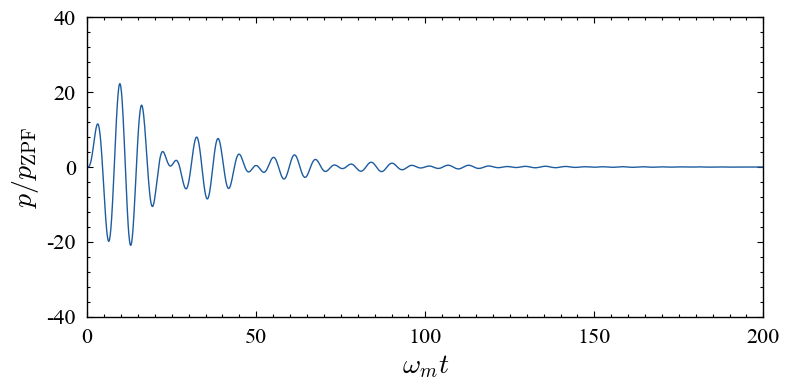

In [4]:
# update plotter parameters
plotter_params.update({
    'v_label': '$p / p_{\\mathrm{ZPF}}$',
    'component': 'imag',
})
# reinitialize plotter components
plotter = MPLPlotter(
    axes={},
    params=plotter_params
)
# plot values with time
plotter.update(
    vs=np.sqrt(2.0) * Modes.transpose()[0],
    xs=T
)
plotter.show()

`MPLPlotter` also supports twin axes and both the position and momentum can be easily plotted simultaneously as follows...

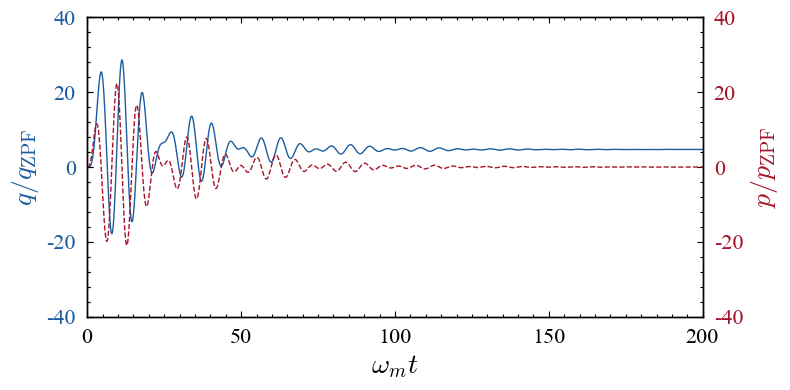

In [5]:
# plotter parameters
plotter_params = {
    'type': 'lines',
    'palette': 'RdBu_r',
    'x_label': '$\\omega_{m} t$',
    'x_ticks': list(range(0, 201, 50)),
    'x_ticks_minor': list(range(0, 201, 5)),
    'v_label': '$q / q_{\\mathrm{ZPF}}$',
    'v_label_color': 0,
    'v_tick_color': 0,
    'v_ticks': list(range(-40, 41, 20)),
    'v_ticks_minor': list(range(-40, 41, 4)),
    'v_twin_label': '$p / p_{\\mathrm{ZPF}}$',
    'v_twin_label_color': -1,
    'v_twin_tick_color': -1,
    'v_twin_ticks': list(range(-40, 41, 20)),
    'v_twin_ticks_minor': list(range(-40, 41, 4)),
    'component': 'real',
    'width': 8.0,
    'height': 4.0
}
# initialize plotter
plotter = MPLPlotter(
    axes={},
    params=plotter_params
)
# plot values with time
plotter.update(
    vs=np.sqrt(2.0) * np.real(Modes.transpose()[0]),
    xs=T
)
plotter.update_twin_axis(
    vs=np.sqrt(2.0) * np.imag(Modes.transpose()[0]),
    xs=T
)
plotter.show()

## Nonlinear Classical Dynamics

In the above simulation, the dynamical variable $\beta$ can be seen to settle down to a fixed point after an initial transient.
This can be represented in the phase-space trajectory by ploting both the components, which represent position and momentum, simultaneously.
Let us utilize `MPLPlotter` once again to plot the phase trajectory of $\beta$...

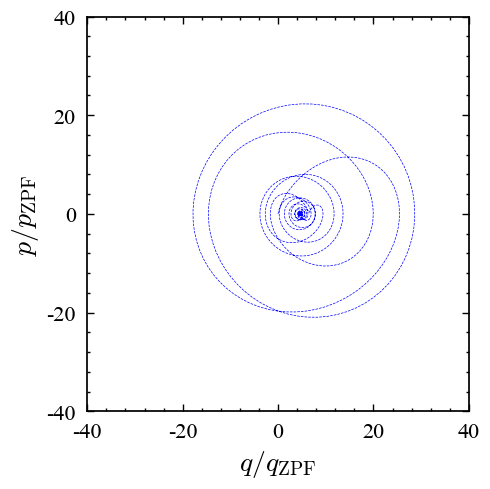

In [6]:
# extract position and momentum
q_fp = np.sqrt(2.0) * np.real(Modes.transpose()[0])
p_fp = np.sqrt(2.0) * np.imag(Modes.transpose()[0])

# initialize the plotter
plotter = MPLPlotter(
    axes={},
    params={
        'type': 'lines',
        'colors': ['b', 'r'],
        'sizes': [0.5, 1],
        'styles': ['--', '-'],
        'x_label': '$q / q_{\\mathrm{ZPF}}$',
        'x_ticks': list(range(-40, 41, 20)),
        'x_ticks_minor': list(range(-40, 41, 4)),
        'v_label': '$p / p_{\\mathrm{ZPF}}$',
        'v_ticks': list(range(-40, 41, 20)),
        'v_ticks_minor': list(range(-40, 41, 4)),
        'height': 5.0,
        'width': 5.0
    }
)
# update and show
plotter.update(
    vs=[p_fp, p_fp[-628:]],
    xs=[q_fp, q_fp[-628:]]
)
plotter.show()

It can be seen here that the trajectory eventually settles at a fixed point. 

On the other hand, if we vary the parameter slightly (say increase $A_{l}$ to $50.0 \omega_{m}$), the real and imaginary components settle down to an oscillatory state.
Let us see how the phase-space trajectory of such dynamics looks like...

MainThread               INFO    2023-07-13 13:16:03.520: (qom.solvers.HLESolver) ----------------------------------------Results Obtained	


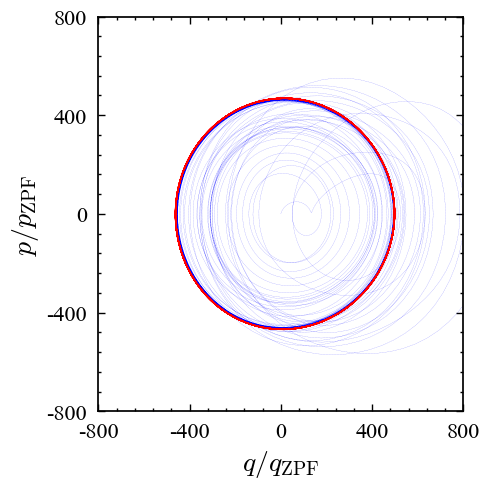

In [7]:
# update system parameter
system_params.update({
    'A_l_norm': 50.0
})
# reinitialize system
system = EM_00(
    params=system_params
)
# initialize solver
solver_hle = HLESolver(
    system=system,
    params=solver_params
)
# get times and modes
T = solver_hle.T
Modes = solver_hle.get_mode_indices()

# extract position and momentum
q_lc = np.sqrt(2.0) * np.real(Modes.transpose()[0])
p_lc = np.sqrt(2.0) * np.imag(Modes.transpose()[0])

# initialize the plotter
plotter = MPLPlotter(
    axes={},
    params={
        'type': 'lines',
        'colors': ['b', 'r'],
        'sizes': [0.1, 1],
        'styles': ['--', '-'],
        'x_label': '$q / q_{\\mathrm{ZPF}}$',
        'x_ticks': list(range(-800, 801, 400)),
        'x_ticks_minor': list(range(-800, 801, 80)),
        'v_label': '$p / p_{\\mathrm{ZPF}}$',
        'v_ticks': list(range(-800, 801, 400)),
        'v_ticks_minor': list(range(-800, 801, 80)),
        'height': 5.0,
        'width': 5.0
    }
)
# update and show
plotter.update(
    vs=[p_lc, p_lc[-628:]],
    xs=[q_lc, q_lc[-628:]]
)
plotter.show()

Here, the last few oscillations are marked in red.
It can be seen that the trajectory traces a closed loop, known as limit cycles.
If we increase the amplitudes further, the system becomes unstable.

However, if we increase the value of the amplitude further (say $A_l = 100.0 \omega_{m}$) for a highly dissipative cavity (say $\kappa = \omega_{m}$), the dynamics does not converge and in certain cases, displays chaotic behaviour.
This can be viewed below.

MainThread               INFO    2023-07-13 13:16:07.711: (qom.solvers.HLESolver) ----------------------------------------Results Obtained	


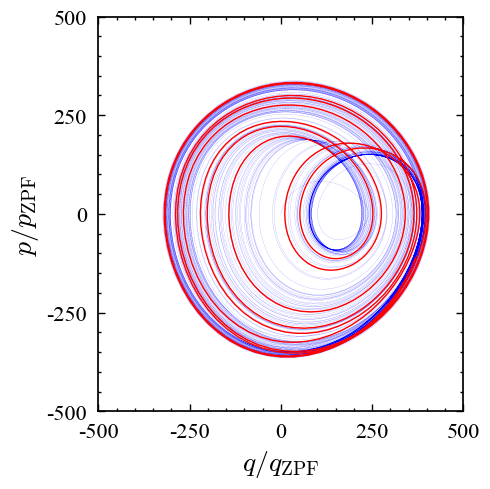

In [8]:
# update system parameter
system_params.update({
    'A_l_norm': 100.0,
    'kappa_norm': 1.0
})
# reinitialize system
system = EM_00(
    params=system_params
)
# initialize solver
solver_hle = HLESolver(
    system=system,
    params=solver_params
)
# get times and modes
T = solver_hle.T
Modes = solver_hle.get_mode_indices()

# extract position and momentum
q_cb = np.sqrt(2.0) * np.real(Modes.transpose()[0])
p_cb = np.sqrt(2.0) * np.imag(Modes.transpose()[0])

# initialize the plotter
plotter = MPLPlotter(
    axes={},
    params={
        'type': 'lines',
        'colors': ['b', 'r'],
        'sizes': [0.1, 1],
        'styles': ['--', '-'],
        'x_label': '$q / q_{\\mathrm{ZPF}}$',
        'x_ticks': list(range(-500, 501, 250)),
        'x_ticks_minor': list(range(-500, 501, 50)),
        'v_label': '$p / p_{\\mathrm{ZPF}}$',
        'v_ticks': list(range(-500, 501, 250)),
        'v_ticks_minor': list(range(-500, 501, 50)),
        'height': 5.0,
        'width': 5.0
    }
)
# update and show
plotter.update(
    vs=[p_cb, p_cb[-628:]],
    xs=[q_cb, q_cb[-628:]]
)
plotter.show()

## Optomechanical Bistability

In the adiabatic limit ($\kappa \gg \gamma, g_{0}$), the classical modes can be expressed as steady state values 
$$
\alpha_{s} = \frac{A_{l}}{\frac{\kappa}{2} - i \Delta}, \\
\beta_{s} = \frac{i g_{0} \left| \alpha_{s} \right|^{2}}{\frac{\gamma}{2} + i \omega_{m}}.
$$

These equations can be simplified as a cubic in $N_{o} = | \alpha_{s} |^{2}$ given by
$$
4 C^{2} N^{3} + 8 C \Delta_{0} N^{2} + ( 4 \Delta_{0}^{2} + \kappa^{2} ) N - 4 \left| A_{l} \right|^{2} = 0,
$$
where $C = 2 g_{0}^{2} \omega_{m} / ( \gamma^{2} / 4 + \omega_{m}^{2} )$.
We can now obtain the solutions to this cubic equation for different values of $\Delta_{0}$ by using the `get_mean_optical_occupancies` method to solve the cubic equation of the system (requires the `get_coeffs_N_o` method in [EM_00 class](../../systems/EndMirror.py)) and the wrapper functions available in `qom.utils.loopers` as shown below:

MainThread               INFO    2023-07-13 13:16:08.202: (qom.loopers.XLooper) ----------------------------------------Looper Initialized	


MainThread               INFO    2023-07-13 13:16:09.566: (qom.loopers.XLooper) ----Reshaping with NaN values (BaseLooper): New Length = 3	
MainThread               INFO    2023-07-13 13:16:09.585: (qom.loopers.XLooper) ------------------------------------------Results Obtained	


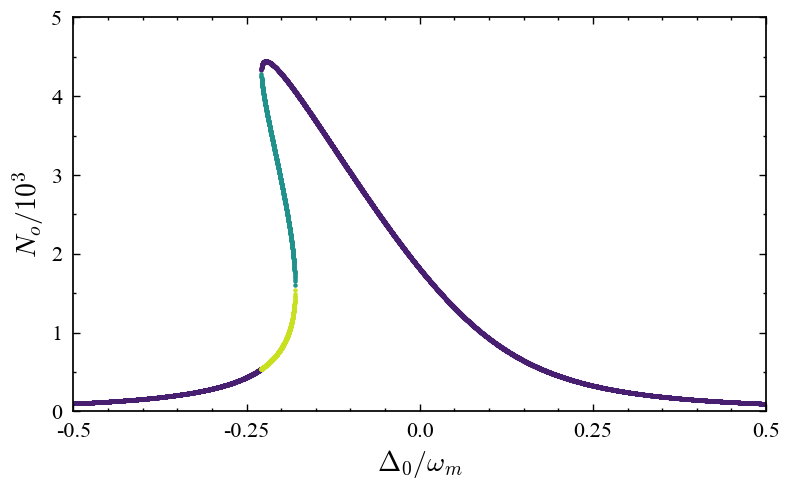

In [9]:
# qom modules
from qom.utils.loopers import wrap_looper

# all parameters
params = {
    'looper': {
        'show_progress': True,
        'X': {
            'var': 'Delta_0_norm',
            'val': np.linspace(-0.5, 0.5, 10001)
        }
    },
    'system': {
        'A_l_norm': 5.0,
        'Delta_0_norm': -1.0, 
        'g_0_norm': 0.005,
        'gamma_norm': 0.005,
        'kappa_norm': 0.15,
        'T_norm': 0.0
    },
    'plotter': {
        'type': 'scatters',
        'palette': 'viridis',
        'colors': [0, 5, 10],
        'sizes': [5.0] * 3,
        'styles': ['o'] * 3,
        'x_label': '$\\Delta_{0} / \\omega_{m}$',
        'x_ticks': [-0.5, -0.25, 0.0, 0.25, 0.5],
        'x_ticks_minor': [i * 0.05 - 0.5 for i in range(21)],
        'v_label': '$N_{o} / 10^{3}$',
        'v_tick_labels': list(range(0, 6)),
        'v_ticks': list(range(0, 5001, 1000)),
        'v_ticks_minor': list(range(0, 5001, 500)),
        'width': 8.0
    }
}

# function to obtain the mean optical occupancies
def func_moo(system_params):
    # initialize system
    system = EM_00(
        params=system_params
    )
    # get mean optical occupancies
    N_os = system.get_mean_optical_occupancies()
    
    return N_os

# wrap looper
looper = wrap_looper(
    looper_name='XLooper',
    func=func_moo,
    params=params['looper'],
    params_system=params['system']
)

# plotter
plotter = MPLPlotter(
    axes={},
    params=params['plotter']
)
plotter.update(
    vs=np.transpose(looper.results['V']),
    xs=looper.results['X']
)
plotter.show()

Together with variation in the optomechanical strength $g_{0}$, a similar plot can be quickly obtained by wrapping a 2D looper:

MainThread               INFO    2023-07-13 13:16:10.051: (qom.loopers.XYLooper) ---------------------------------------Looper Initialized	
MainThread               INFO    2023-07-13 13:16:14.707: (qom.loopers.XYLooper) ---Reshaping with NaN values (BaseLooper): New Length = 3	
MainThread               INFO    2023-07-13 13:16:16.200: (qom.loopers.XYLooper) ---Reshaping with NaN values (BaseLooper): New Length = 3	
MainThread               INFO    2023-07-13 13:16:16.227: (qom.loopers.XYLooper) -----------------------------------------Results Obtained	


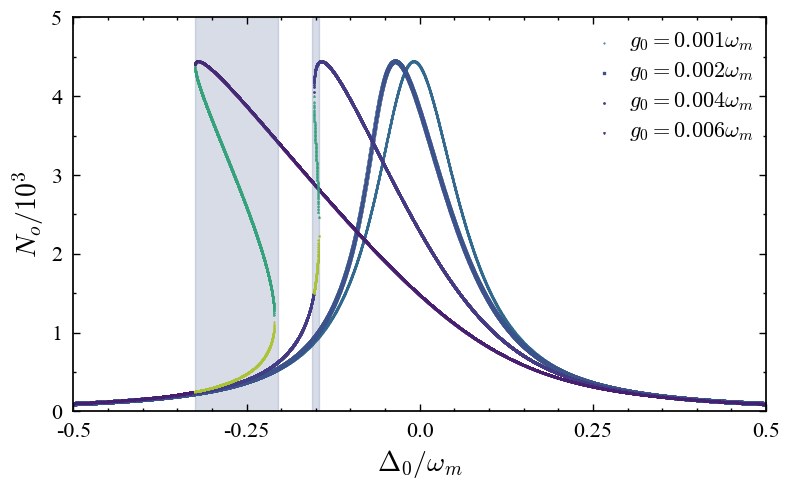

In [10]:
# wrap looper
looper = wrap_looper(
    looper_name='XYLooper',
    func=func_moo,
    params={
        'show_progress': True,
        'X': {
            'var': 'Delta_0_norm',
            'min': -0.5,
            'max': 0.5,
            'dim': 10001,
        },
        'Y': {
            'var': 'g_0_norm',
            'val': [0.001, 0.002, 0.004, 0.006]
        }
    },
    params_system={
        'A_l_norm': 5.0,
        'Delta_0_norm': -1.0, 
        'g_0_norm': 0.005,
        'gamma_norm': 0.005,
        'kappa_norm': 0.15,
        'T_norm': 0.0
    }
)

# plotter
plotter = MPLPlotter(
    axes={},
    params={
        'type': 'scatters',
        'palette': 'viridis',
        'colors': [3, 2, 1, 0, 7, 10, 7, 10],
        'x_label': '$\\Delta_{0} / \\omega_{m}$',
        'x_ticks': [i * 0.25 - 0.5 for i in range(5)],
        'x_ticks_minor': [i * 0.05 - 0.5 for i in range(21)],
        'v_label': '$N_{o} / 10^{3}$',
        'v_tick_labels': list(range(0, 6)),
        'v_ticks': list(range(0, 5001, 1000)),
        'v_ticks_minor': list(range(0, 5001, 500)),
        'show_legend': True,
        'legend_labels': [
            '$g_{0} = 0.001 \\omega_{m}$',
            '$g_{0} = 0.002 \\omega_{m}$',
            '$g_{0} = 0.004 \\omega_{m}$',
            '$g_{0} = 0.006 \\omega_{m}$'
        ],
        'width': 8.0,
        'legend_font_size': 16.0,
        'vertical_spans': [{
            'limits': (-0.325, -0.205),
            'color': 2,
            'alpha': 0.2
        }, {
            'limits': (-0.155, -0.145),
            'color': 2,
            'alpha': 0.2
        }]
    }
)
V = looper.results['V']
plotter.update(
    vs=[[V[i][j][0] for j in range(len(V[i]))] for i in range(len(V))] + [[V[2][j][i] for j in range(len(V[2]))] for i in range(1, 3)] + [[V[3][j][i] for j in range(len(V[2]))] for i in range(1, 3)],
    xs=looper.results['X'][0]
)
plotter.show()

One can also plot the optical stability zones for different values of $\Delta_{0}$ and $A_{l}$ by utilizing the `XYLooper`. To do this, we utilize the `qom.solvers.stability` module, which is wrapped for the drift matrix approach by the `get_func_stability_zone` function in the `qom.utils.solvers` module. Let us give it a try!

MainThread               INFO    2023-07-13 13:16:19.044: (qom.loopers.XYLooper) ---------------------------------------Looper Initialized	
MainThread               INFO    2023-07-13 13:23:08.407: (qom.loopers.XYLooper) -----------------------------------------Results Obtained	


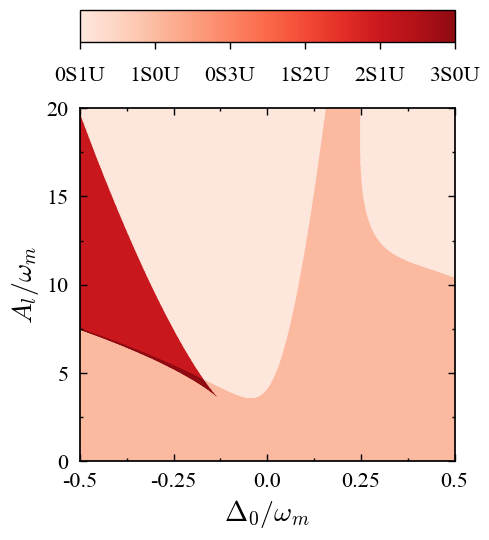

In [11]:
# qom modules
from qom.utils.solvers import get_func_stability_zone

# frequently used parameters
use_rhc=False

# all parameters
params = {
    'looper': {
        'show_progress': True,
        # 'file_path_prefix': '../../data/systems/em_00_sz_' + ('rhc' if use_rhc else 'eig'),
        'X': {
            'var': 'Delta_0_norm',
            'min': -0.5,
            'max': 0.5,
            'dim': 1001,
        },
        'Y': {
            'var': 'A_l_norm',
            'min': 0.0,
            'max': 20.0,
            'dim': 1001
        }
    },
    'solver': {
        'show_progress': False,
        'method': 'eig',
        'system_measure_name': 'A'
    },
    'system': {
        'A_l_norm': 5.0,
        'Delta_0_norm': -1.0, 
        'g_0_norm': 0.005,
        'gamma_norm': 0.005,
        'kappa_norm': 0.15,
        'T_norm': 0.0
    },
    'plotter': {
        'type': 'pcolormesh',
        'palette': 'Reds',
        'x_label': '$\\Delta_{0} / \\omega_{m}$',
        'x_ticks': [i * 0.25 - 0.5 for i in range(5)],
        'x_ticks_minor': [i * 0.125 - 0.5 for i in range(9)],
        'y_label': '$A_{l} / \\omega_{m}$',
        'y_ticks': list(range(0, 21, 5)),
        'y_ticks_minor': [i * 2.5 for i in range(9)],
        'show_cbar': True,
        'cbar_position': 'top',
        'cbar_tick_labels': ['0S1U', '1S0U', '0S3U', '1S2U', '2S1U', '3S0U'],
        'cbar_ticks': [0, 1, 2, 3, 4, 5]
    }
}

# wrap looper and plot
looper = wrap_looper(
    looper_name='XYLooper',
    func=get_func_stability_zone(
        SystemClass=EM_00,
        params=params['solver'],
        steady_state=True,
        use_rhc=use_rhc
    ),
    params=params['looper'],
    params_system=params['system'],
    plot=True,
    params_plotter=params['plotter']
)

Jeez, that took a lot of time!
But by using the multiprocessing features of the `qom.utils.loopers` module, we can speed up the execution manifold!
To check the speed-up yourself, try running the [stability zone example script](../../scripts/systems/em_00_stability_zone.py) from the terminal.

In the above figure, 'S' denotes a stable branch, whereas 'U' denotes an unstable one.
The integers preceeding these alphabets denote the number of such branches for each set of parameters.

## Optomechanical Damping and Optical Spring Effect

Two charasteristic outcomes of the optomechanical interaction are the optomechanical damping and the optical spring effect. 
In the first case, the linear mechanical response contains an extra damping term which results in the heating or cooling of the mechanical motion.
This optomechanical damping rate is given as
$$
\gamma_{om} = g_{s}^{2} \kappa \left\{ \frac{1}{\kappa^{2} / 4 + \left( \omega_m + \Delta \right)} - \frac{1}{\kappa^{2} / 4 + \left( \omega_m - \Delta \right)} \right\}.
$$

In the second scenario, the frequency of the mechanical oscillator gets shifted due to the optical field by an amount of
$$
\delta \omega_{m} = g_{s}^{2} \kappa \left\{ \frac{\omega_{m} + \Delta}{\kappa^{2} / 4 + \left( \omega_m + \Delta \right)} - \frac{\omega_{m} - \Delta}{\kappa^{2} / 4 + \left( \omega_m - \Delta \right)} \right\}.
$$
This shift results in the softening or hardening of the mechanical spring constant.

By defining the custom methods `get_optomechanical_damping_rate_norm` and `get_optomechanical_frequency_shift_norm` in our [EM_00 class](../../systems/EndMirror.py) to calculate and return the normalized damping rate and the normalized frequency shift respectively, we can obtain the typical behaviour of these curves with change in the detuning as shown below:

MainThread               INFO    2023-07-13 13:23:16.608: (qom.loopers.XYLooper) ---------------------------------------Looper Initialized	


MainThread               INFO    2023-07-13 13:23:17.488: (qom.loopers.XYLooper) -----------------------------------------Results Obtained	


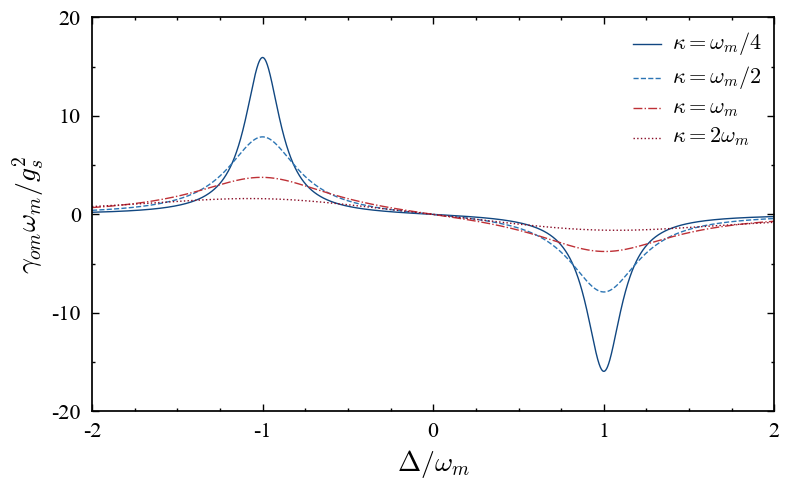

In [12]:
# all parameters
params = {
    'looper': {
        'show_progress': True,
        'X': {
            'var': 'Delta_0_norm',
            'min': -2.0,
            'max': 2.0,
            'dim': 4001,
        },
        'Y': {
            'var': 'kappa_norm',
            'val': [0.25, 0.5, 1.0, 2.0]
        }
    },
    'system': {
        'A_l_norm': 5.0,
        'Delta_0_norm': -1.0, 
        'g_0_norm': 0.005,
        'gamma_norm': 0.005,
        'kappa_norm': 0.15,
        'T_norm': 0.0
    },
    'plotter': {
        'type': 'lines',
        'bins': 21,
        'colors': [0, 2, -3, -1],
        'sizes': [1] * 4,
        'x_label': '$\\Delta / \\omega_{m}$',
        'x_ticks': [i - 2 for i in range(5)],
        'x_ticks_minor': [i * 0.25 - 2.0 for i in range(17)],
        'show_legend': True,
        'legend_labels': [
            '$\kappa = \omega_{m} / 4$', 
            '$\kappa = \omega_{m} / 2$', 
            '$\kappa = \omega_{m}$', 
            '$\kappa = 2 \omega_{m}$'
        ],
        'width': 8.0
    }
}

# function to obtain the normalized optomechanical damping rate
def func(system_params):
    # initialize system
    system = EM_00(
        params=system_params
    )
    # get derived constants and controls
    _, _, c = system.get_ivc()
    # get rate
    return system.get_optomechanical_damping_rate_norm(
        c=c
    )

# wrap looper for normalized optomechanical damping rate
params['plotter'].update({
    'v_label': '$\\gamma_{om} \\omega_{m} / g_{s}^{2}$',
    'v_ticks': [-20, -10, 0, 10, 20],
    'v_ticks_minor': [i * 5 - 20 for i in range(9)]
})
looper = wrap_looper(
    looper_name='XYLooper',
    func=func,
    params=params['looper'],
    params_system=params['system'],
    plot=True,
    params_plotter=params['plotter']
)

MainThread               INFO    2023-07-13 13:23:18.012: (qom.loopers.XYLooper) ---------------------------------------Looper Initialized	
MainThread               INFO    2023-07-13 13:23:18.879: (qom.loopers.XYLooper) -----------------------------------------Results Obtained	


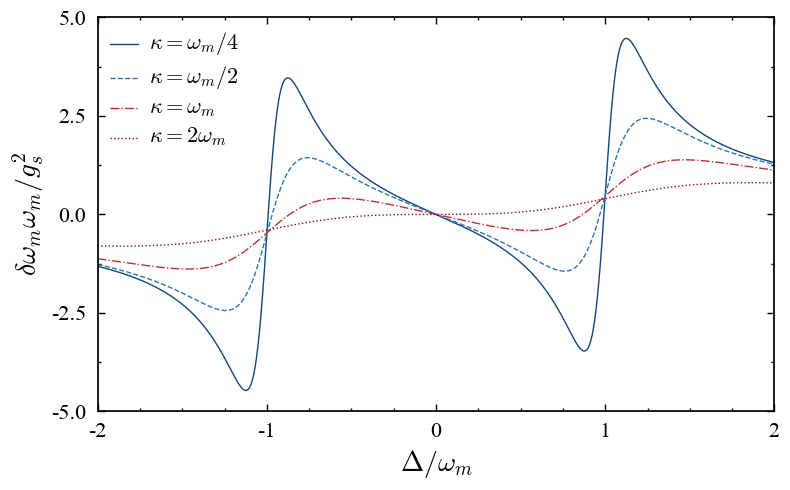

In [13]:
# function to obtain the normalized optomechanical frequency shift
def func(system_params):
    # initialize system
    system = EM_00(
        params=system_params
    )
    # get derived constants and controls
    _, _, c = system.get_ivc()
    # get rate
    return system.get_optomechanical_frequency_shift_norm(
        c=c
    )

# wrap looper for normalized optomechanical frequency shift
params['plotter'].update({
    'v_label': '$\\delta \\omega_{m} \\omega_{m} / g_{s}^{2}$',
    'v_ticks': [-5, -2.5, 0, 2.5, 5],
    'v_ticks_minor': [i * 1.25 - 5 for i in range(9)]
})
looper = wrap_looper(
    looper_name='XYLooper',
    func=func,
    params=params['looper'],
    params_system=params['system'],
    plot=True,
    params_plotter=params['plotter']
)

## Correlations between the Quantum Fluctuations

The correlations between the quantum fluctuations are simulated through the correlation matrix $\mathbf{V}$.
The following script demonstrates the simulation of quantum correlations by calculating the dynamical values of the variances in position and momentum of the mechanical mode, which correspond to the elements $\mathbf{V}_{22}$ and $\mathbf{V}_{33}$ respectively.
This can be achieved using the `get_corr_indices` method in `HLESolver` as follows:

MainThread               INFO    2023-07-13 13:23:19.862: (qom.solvers.HLESolver) ----------------------------------------Results Obtained	


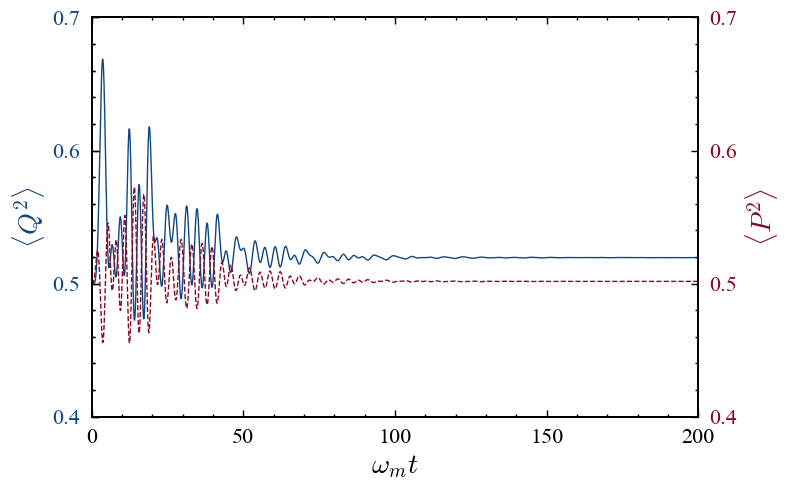

In [14]:
# initialize system
system = EM_00(
    params={
        'A_l_norm': 25.0,
        'Delta_0_norm': -1.0, 
        'g_0_norm': 0.005,
        'gamma_norm': 0.005,
        'kappa_norm': 0.15,
        'T_norm': 0.0
    }
)
# get dynamics of specific correlations
hle_solver = HLESolver(
    system=system,
    params={
        'show_progress': True,
        'cache': False,
        'ode_method': 'vode',
        'indices': [(2, 2), (3, 3)],
        't_min': 0.0,
        't_max': 1000.0,
        't_dim': 10001
    }
)
# get times and correlations
T = hle_solver.T
Corrs = hle_solver.get_corr_indices()

# initialize plotter
plotter = MPLPlotter(
    axes={},
    params={
        'type': 'lines',
        'palette': 'RdBu_r',
        'bins': 21,
        'x_label': '$\\omega_{m} t$',
        'x_ticks': list(range(0, 201, 50)),
        'x_ticks_minor': list(range(0, 201, 10)),
        'v_label': '$\\langle Q^{2} \\rangle$',
        'v_label_color': 0,
        'v_tick_color': 0,
        'v_ticks': [0.4, 0.5, 0.6, 0.7],
        'v_ticks_minor': [i * 0.02 + 0.4 for i in range(16)],
        'v_twin_label': '$\\langle P^{2} \\rangle$',
        'v_twin_label_color': -1,
        'v_twin_tick_color': -1,
        'v_twin_ticks': [0.4, 0.5, 0.6, 0.7],
        'v_twin_ticks_minor': [i * 0.02 + 0.4 for i in range(16)],
        'width': 8.0
    }
)
# update and show
plotter.update(
    vs=Corrs.transpose()[0],
    xs=T
)
plotter.update_twin_axis(
    vs=Corrs.transpose()[1],
    xs=T
)
plotter.show()

If we just want to utilize the steady state values, the corresponding `get_corr_indices` method in `SSHLESolver` can be used. Let us see if these match our simulated values...

In [15]:
# qom modules
from qom.solvers.deterministic import SSHLESolver

# initialize solver
sshle_solver = SSHLESolver(
    system=system,
    params={
        'show_progress': True,
        'indices': [(2, 2), (3, 3)]
    }
)
print('Steady state Heisenberg-Langevin equations solver result (using mean optical occupancies):\t\n{}'.format(sshle_solver.get_corr_indices()))
print('Heisenberg-Langevin equations solver result:\t\n{}'.format(Corrs[-1]))

Steady state Heisenberg-Langevin equations solver result (using mean optical occupancies):	
[[-7.31754811  0.62350814]
 [ 4.46357756  0.57758434]
 [ 0.51926253  0.5015354 ]]
Heisenberg-Langevin equations solver result:	
[0.51949963 0.50164472]


The third steady-state value is close enough!
The other values don't match exactly since our system method `get_modes_steady_state` uses a root-finding method to determine the mean optical occupancies and using these occupancies, calculate the mode amplitudes.
On the other hand, the dynamical equations are obtained using the `get_mode_rates` method.
To use the same method, we can set the "use_system_method" parameter to `False`.
Let's see what this gives us...

In [16]:
# initialize solver
sshle_solver = SSHLESolver(
    system=system,
    params={
        'show_progress': True,
        'indices': [(2, 2), (3, 3)],
        'use_system_method': False
    }
)
print('Steady state Heisenberg-Langevin equations solver result (solving the rate equations)):\t\n{}'.format(sshle_solver.get_corr_indices()))
print('Heisenberg-Langevin equations solver result:\t\n{}'.format(Corrs[-1]))

Steady state Heisenberg-Langevin equations solver result (solving the rate equations)):	
[[0.51949963 0.50164472]]
Heisenberg-Langevin equations solver result:	
[0.51949963 0.50164472]


As expected, they give the exact same result!

## Optomechanical Entanglement

To study the nature of quantum entanglement between the optical and mechanical modes, we utilize the logarithmic negativity measure defined for the bipartite matrix $V$ written in the standard form
$$
\mathbf{V} = \begin{pmatrix}
    \mathcal{A} & \mathcal{C} \\
    \mathcal{C}^{T} & \mathcal{B}
\end{pmatrix},
$$
where $\mathcal{A}$, $\mathcal{B}$ and $\mathcal{C}$ are $2 \times 2$ matrices.
The degree of entanglement is then quantified by the figure of merit
$$
E_{N} = \mathrm{max} \left[ 0, - \ln \left( 2 \mu^{-} \right) \right],
$$ 
where $\mu^{-} = 2^{-1/2} \left\{ \Sigma - \sqrt{\Sigma^{2} - 4 \mathrm{det} \left[ \mathbf{V} \right]} \right\}$ with $\Sigma = \mathrm{det} \left[ \mathcal{A} \right] + \mathrm{det} \left[ \mathcal{B} \right] - 2 \mathrm{det} \left[ \mathcal{C} \right]$.

Let us utlilize the dynamics of the modes and correlations to obtain the dynamics of this measure between the optical (indexed `0`) and mechanical (indexed `1`) modes by using the `get_measures` method in `QCMSolver` with the `measure_codes` parameter set to `['entan_ln']`:

MainThread               INFO    2023-07-13 13:23:20.313: (qom.solvers.QCMSolver) ---------------------------------------Measures Obtained	


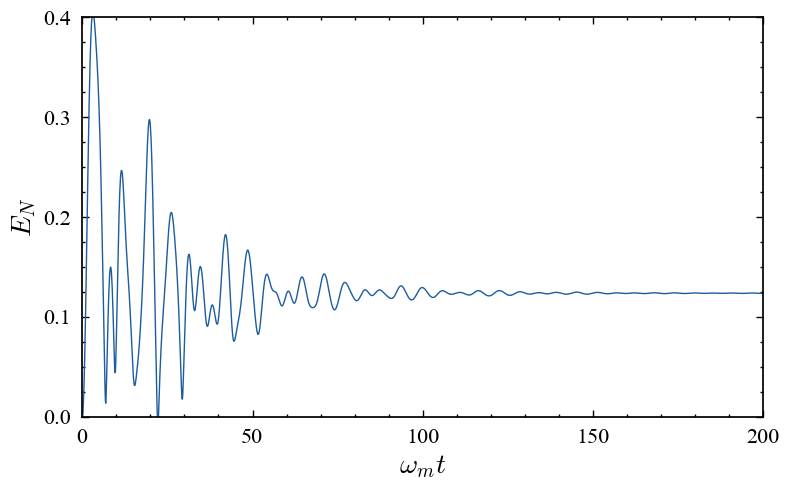

In [17]:
# qom modules
from qom.solvers.measure import QCMSolver

# get times, modes and correlations
T = hle_solver.get_times()
Modes = hle_solver.get_modes()
Corrs = hle_solver.get_corrs()

# get entanglement values
vs = QCMSolver(
    Modes=Modes,
    Corrs=Corrs,
    params={
        'show_progress': True,
        'measure_codes': ['entan_ln'],
        'indices': [0, 1]
    }
).get_measures()

# initialize plotter
plotter = MPLPlotter(
    axes={},
    params={
        'type': 'lines',
        'x_label': '$\\omega_{m} t$',
        'x_ticks': list(range(0, 201, 50)),
        'x_ticks_minor': list(range(0, 201, 10)),
        'v_label': '$E_{N}$',
        'v_ticks': [0.0, 0.1, 0.2, 0.3, 0.4],
        'v_ticks_minor': [i * 0.025 for i in range(17)],
        'show_legend': True,
        'width': 8.0
    }
)
# plot values with time
plotter.update(
    vs=vs,
    xs=T
)
plotter.show()

One can also obtain the steady state values of entanglement in the stable regions of the system without having to define any solver function.
To achieve this, the `qom.utils.solvers` module wraps everything in its `get_func_quantum_correlation_measures` function.

We demonstrate this wrapped function together with the `wrap_looper` function in the execution below:

MainThread               INFO    2023-07-13 13:23:20.589: (qom.loopers.XYLooper) ---------------------------------------Looper Initialized	
MainThread               INFO    2023-07-13 13:36:01.028: (qom.loopers.XYLooper) -----------------------------------------Results Obtained	


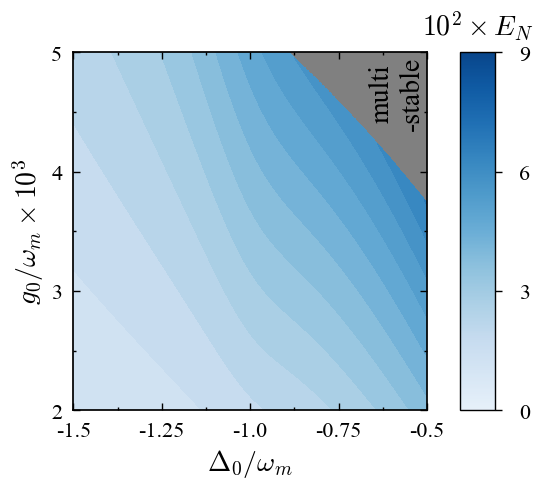

In [18]:
# qom modules
from qom.utils.solvers import get_func_quantum_correlation_measures

# all parameters
params = {
    'looper': {
        'show_progress': True,
        # 'file_path_prefix': '../../data/systems/em_00_en_sz',
        'X': {
            'var': 'Delta_0_norm',
            'min': -1.5,
            'max': -0.5,
            'dim': 1001
        },
        'Y': {
            'var': 'g_0_norm',
            'min': 0.002,
            'max': 0.005,
            'dim': 901
        }
    },
    'solver': {
        'show_progress': False,
        'method': 'eig',
        'measure_codes': ['entan_ln'],
        'indices': (0, 1),
        'system_measure_name': 'A'
    },
    'system': {
        'A_l_norm': 10.0,
        'Delta_0_norm': -1.0, 
        'g_0_norm': 0.005,
        'gamma_norm': 0.005,
        'kappa_norm': 0.15,
        'T_norm': 0.0
    },
    'plotter': {
        'type': 'contourf',
        'palette': 'Blues',
        'x_label': '$\\Delta_{0} / \\omega_{m}$',
        'x_ticks': [i * 0.25 - 1.5 for i in range(5)],
        'x_ticks_minor': [i * 0.125 - 1.5 for i in range(9)],
        'y_label': '$g_{0} / \\omega_{m} \\times 10^{3}$',
        'y_tick_labels': list(range(2, 6)),
        'y_ticks': [i * 0.001 + 0.002 for i in range(4)],
        'y_ticks_minor': [i * 0.0005 + 0.002 for i in range(7)],
        'show_cbar': True,
        'cbar_title': '$10^{2} \\times E_{N}$',
        'cbar_tick_labels': [0, 3, 6, 9],
        'cbar_ticks': [0.0, 0.03, 0.06, 0.09],
        'annotations': [{
            'text': 'multi\n-stable',
            'xy': (0.67, 0.73),
            'orientation': 'vertical'
        }]
    }
}

# function to obtain the steady state entanglement in stable zones
def func(system_params):
    # get stability zone
    sz = get_func_stability_zone(
        SystemClass=EM_00,
        params=params['solver'],
        steady_state=True,
        use_rhc=False
    )(system_params)[0]
    # get entanglement if stable
    if sz == 1:
        return get_func_quantum_correlation_measures(
            SystemClass=EM_00,
            params=params['solver'],
            steady_state=True
        )(system_params)[0, 0]
    
    return np.NaN

# wrap looper and plot
looper = wrap_looper(
    looper_name='XYLooper',
    func=func,
    params=params['looper'],
    params_system=params['system'],
    plot=True,
    params_plotter=params['plotter']
)

To check the speed-up using multiprocessing, try running the [entanglement example script](../../scripts/systems/em_00_entan_ln_stability_zone.py) from the terminal.

## Visualizing the Cached Dynamics

The dynamics for each set of parameters is saved temporarily in the `'cache'` folder .
By default, the folder contains folders for each model saved by a codename `sys_xx`, which is a lower-case version of the system's class name (e.g., `em_00` for `EM_00`).
Then, folders corresponding to the time series taken are written in the `min_max_dim_method` format.
Inside this, the compressed NumPy arrays are written with the choronological order of parameters as defined in the class constructor of the model.
This default structure can be summed up as
```
data/
├───sys_xx/
│   ├───min_max_dim_method/
│   │   ├───V_foo_bar.npz
│   │   └───...
│   └───...
└───...
```

Each NumPy file contains the dynamics of the real-valued classical mode amplitudes (say $2 n$ in number, first $n$ elements consisting of the real components and the next $n$ containing the imaginary components) and the quantum quadrature correlations ($4 n^{2}$ in number).
For example, the demonstrated system generates time series data for 20 elements ($n=2$).
Let us visualize this...

In [19]:
# import dependencies
import pandas as pd

# get dynamical values
V = hle_solver.results['V']
V_modes = V[:, :2 * hle_solver.system.num_modes]
V_corrs = V[:, 2 * hle_solver.system.num_modes:]
# generate column names for correlations
corrs = ['<{}{} + {}{}> / 2'.format(a, b, b, a) for a in ['X', 'Y', 'Q', 'P'] for b in ['X', 'Y', 'Q', 'P']]
# create a DataFrame for the dynamics
pd.DataFrame(V_modes, columns=['alpha_real', 'beta_real', 'alpha_imag', 'beta_imag']).join(pd.DataFrame(V_corrs, columns=corrs))

,alpha_real,beta_real,alpha_imag,beta_imag,<XX + XX> / 2,<XY + YX> / 2,<XQ + QX> / 2,<XP + PX> / 2,<YX + XY> / 2,<YY + YY> / 2,<YQ + QY> / 2,<YP + PY> / 2,<QX + XQ> / 2,<QY + YQ> / 2,<QQ + QQ> / 2,<QP + PQ> / 2,<PX + XP> / 2,<PY + YP> / 2,<PQ + QP> / 2,<PP + PP> / 2
0,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.500000
1,2.486507,0.000026,-0.124273,0.001035,0.500000,6.152249e-08,0.000062,0.000618,6.152249e-08,0.500001,0.000618,-0.000062,0.000062,0.000618,0.500000,3.097292e-08,0.000618,-0.000062,3.097292e-08,0.500001
2,4.929792,0.000412,-0.493383,0.008206,0.500000,1.918141e-06,0.000489,0.002417,1.918141e-06,0.500012,0.002417,-0.000489,0.000489,0.002417,0.500000,9.781336e-07,0.002417,-0.000489,9.781336e-07,0.500012
3,7.306133,0.002068,-1.099997,0.027402,0.500003,1.404523e-05,0.001622,0.005254,1.404523e-05,0.500057,0.005254,-0.001622,0.001622,0.005254,0.500001,7.298764e-06,0.005254,-0.001622,7.298764e-06,0.500060
4,9.592833,0.006476,-1.934509,0.064132,0.500017,5.646970e-05,0.003756,0.008910,5.646970e-05,0.500170,0.008909,-0.003756,0.003756,0.008909,0.500004,3.009200e-05,0.008910,-0.003756,3.009200e-05,0.500185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,1.994132,3.323532,-25.704746,0.008309,0.500382,-2.810093e-03,0.010680,-0.066355,-2.810093e-03,0.517974,-0.068634,-0.005353,0.010680,-0.068634,0.519500,4.874914e-05,-0.066355,-0.005353,4.874914e-05,0.501645
9997,1.994132,3.323532,-25.704746,0.008309,0.500382,-2.810093e-03,0.010680,-0.066355,-2.810093e-03,0.517974,-0.068634,-0.005353,0.010680,-0.068634,0.519500,4.874916e-05,-0.066355,-0.005353,4.874916e-05,0.501645
9998,1.994132,3.323532,-25.704746,0.008309,0.500382,-2.810093e-03,0.010680,-0.066355,-2.810093e-03,0.517974,-0.068634,-0.005353,0.010680,-0.068634,0.519500,4.874916e-05,-0.066355,-0.005353,4.874916e-05,0.501645
9999,1.994132,3.323532,-25.704746,0.008309,0.500382,-2.810093e-03,0.010680,-0.066355,-2.810093e-03,0.517974,-0.068634,-0.005353,0.010680,-0.068634,0.519500,4.874916e-05,-0.066355,-0.005353,4.874916e-05,0.501645
